In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
100% 148M/149M [00:08<00:00, 16.7MB/s]
100% 149M/149M [00:08<00:00, 18.2MB/s]


In [ ]:
!unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Data preprocessing and augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = ImageFolder('/content/Training', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = ImageFolder('/content/Testing', transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

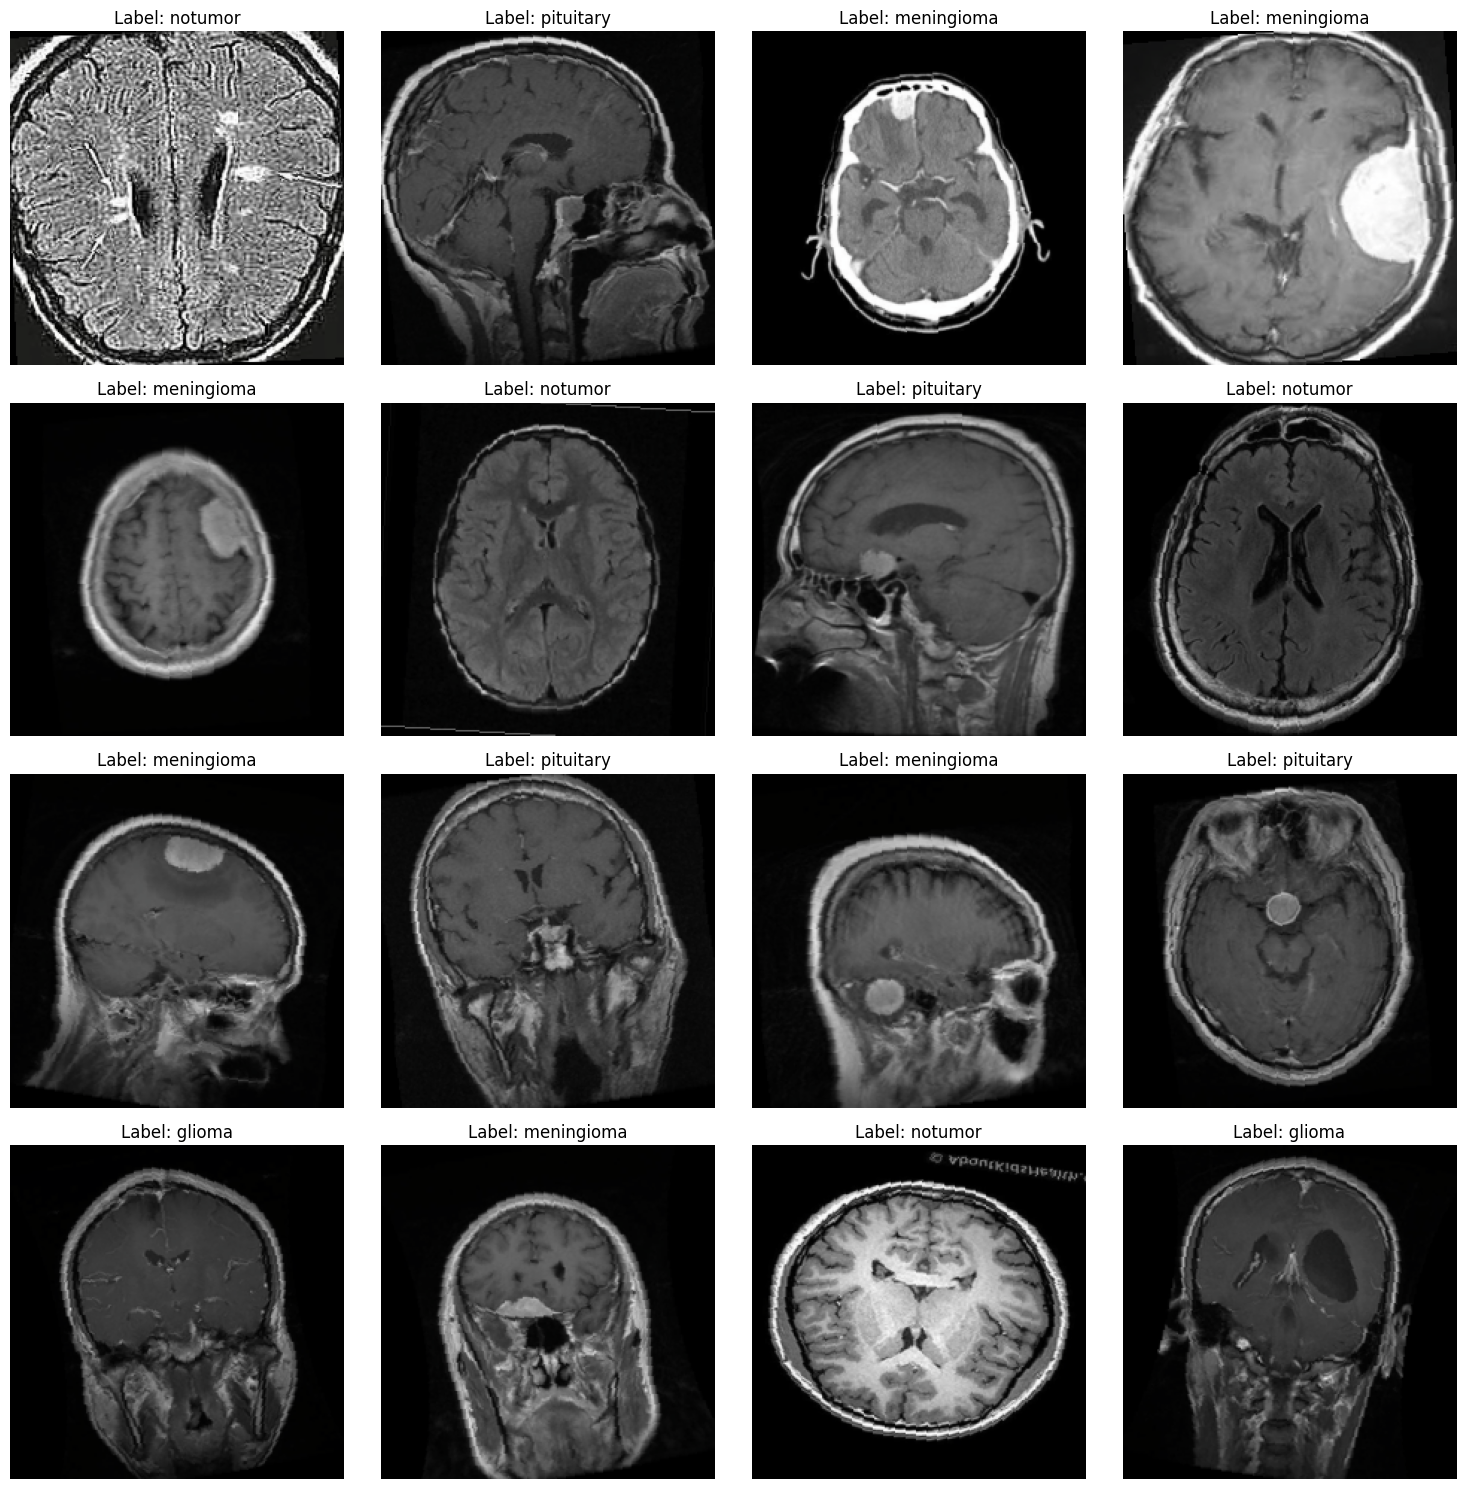

In [ ]:
# Load a batch of images and labels for visualization
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert images to numpy arrays and denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model Architecture

In [ ]:
class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = TumorClassifier(num_classes=4)
# Load a pre-trained ResNet model and modify the classifier
model.to(device)

TumorClassifier(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=100352, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model Training

In [ ]:
# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
num_epochs = 20
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')


    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

Epoch [1/20], Training Loss: 112.0153, Training Accuracy: 87.94%, Validation Loss: 0.4104, Validation Accuracy: 86.12%
Epoch [2/20], Training Loss: 85.4275, Training Accuracy: 91.54%, Validation Loss: 0.3943, Validation Accuracy: 86.65%
Epoch [3/20], Training Loss: 63.6483, Training Accuracy: 93.19%, Validation Loss: 0.2359, Validation Accuracy: 91.15%
Epoch [4/20], Training Loss: 50.4657, Training Accuracy: 94.78%, Validation Loss: 0.1504, Validation Accuracy: 94.51%
Epoch [5/20], Training Loss: 38.3771, Training Accuracy: 96.34%, Validation Loss: 0.1580, Validation Accuracy: 94.89%
Epoch [6/20], Training Loss: 25.5377, Training Accuracy: 97.53%, Validation Loss: 0.1103, Validation Accuracy: 95.80%
Epoch [7/20], Training Loss: 23.1254, Training Accuracy: 97.97%, Validation Loss: 0.1529, Validation Accuracy: 96.41%
Epoch [8/20], Training Loss: 21.9999, Training Accuracy: 98.09%, Validation Loss: 0.0857, Validation Accuracy: 96.64%
Epoch [9/20], Training Loss: 12.8505, Training Accuracy

# Accuracy

In [ ]:
num_epochs = 50
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')


    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

Epoch [1/50], Training Loss: 12.5810, Training Accuracy: 99.00%, Validation Loss: 0.1139, Validation Accuracy: 96.87%
Epoch [2/50], Training Loss: 9.6490, Training Accuracy: 99.32%, Validation Loss: 0.0768, Validation Accuracy: 97.79%
Epoch [3/50], Training Loss: 10.0923, Training Accuracy: 99.14%, Validation Loss: 0.0979, Validation Accuracy: 97.48%
Epoch [4/50], Training Loss: 14.2406, Training Accuracy: 98.93%, Validation Loss: 0.1087, Validation Accuracy: 97.10%
Epoch [5/50], Training Loss: 5.3689, Training Accuracy: 99.49%, Validation Loss: 0.1224, Validation Accuracy: 97.79%
Epoch [6/50], Training Loss: 4.2809, Training Accuracy: 99.60%, Validation Loss: 0.1356, Validation Accuracy: 97.48%
Epoch [7/50], Training Loss: 17.0557, Training Accuracy: 98.77%, Validation Loss: 0.1264, Validation Accuracy: 97.48%
Epoch [8/50], Training Loss: 8.8393, Training Accuracy: 99.14%, Validation Loss: 0.1532, Validation Accuracy: 97.79%
Epoch [9/50], Training Loss: 5.4472, Training Accuracy: 99.5

In [ ]:
accuracy = correct / total
print(f'Validation Accuracy: {accuracy:.2%}')

Validation Accuracy: 98.63%


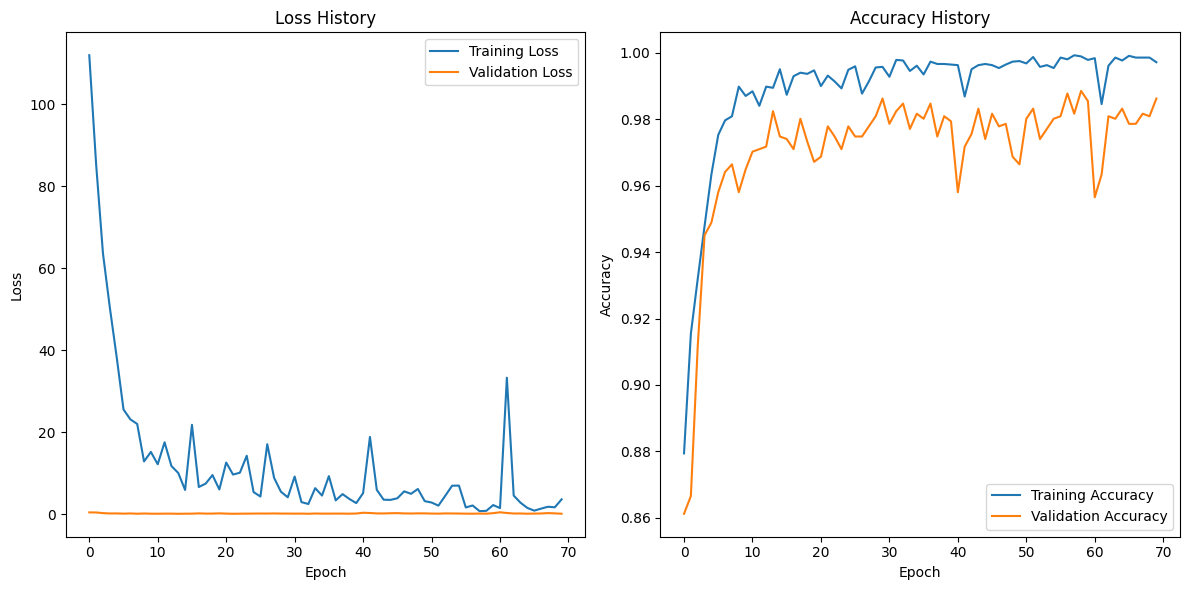

In [ ]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Load the best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

# Prepare the test dataset
test_dataset = ImageFolder('/content/Testing', transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize lists to store true labels and predicted labels
true_labels = []
pred_labels = []

# Test the model
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = np.mean(np.array(true_labels) == np.array(pred_labels))
print(f'Test Accuracy: {accuracy:.2%}')

# Print classification report
print(classification_report(true_labels, pred_labels, target_names=test_dataset.classes))

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
print('Confusion Matrix:')
print(conf_matrix)


Test Accuracy: 98.55%
              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       300
  meningioma       0.97      0.97      0.97       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.98      0.98      1311
weighted avg       0.99      0.99      0.99      1311

Confusion Matrix:
[[292   8   0   0]
 [  2 296   5   3]
 [  0   0 405   0]
 [  1   0   0 299]]
